In [3]:
from helper_funs import *

import numpy as np
from gensim import corpora
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models

with open("pickles/add_stopwords", "rb") as fp:   # Unpickling
    add_stopwords = pickle.load(fp)

with open("pickles/add_characters_to_clean", "rb") as fp:   # Unpickling
    add_characters_to_clean = pickle.load(fp)
    
with open("pickles/selected_popes_names", "rb") as fp:   # Unpickling
    popes = pickle.load(fp)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wmasl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Building blocks of the modelling process

In [4]:
# prepare dataset
df = get_df_of_enc(pope = 'all')
# basic cleaning
df['enc_text_clean'] = df['enc_text'].apply(lambda x:preprocess_text(x,True,True,False,
                                           add_chars_to_clean = add_characters_to_clean , 
                                           add_stopwords = add_stopwords)
                 )
# another column also with tokenization and lemmatization
df['enc_text_lem'] = df['enc_text_clean'].apply(lambda x:preprocess_text(text = x,tokenize = True, lemmatize = True))

### Retrieving bi and trigrams

In [13]:
# Compute bigrams.
# Add bigrams and trigrams to docs (only those that appear 20 times or more).
bigram = models.Phrases(df['enc_text_lem'], min_count=10, connector_words=models.phrases.ENGLISH_CONNECTOR_WORDS)
for idx in range(len(df['enc_text_lem'])):
    for token in bigram[df['enc_text_lem'][idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            df['enc_text_lem'][idx].append(token)
trigram = models.Phrases(bigram[df['enc_text_lem']], min_count=5,connector_words=models.phrases.ENGLISH_CONNECTOR_WORDS )
for idx in range(len(df['enc_text_lem'])):
    for token in trigram[bigram[df['enc_text_lem'][idx]]]:
        if token.count('_') == 2:
            # Token is a trigram, add to document.
            df['enc_text_lem'][idx].append(token)

### Creating and saving corpus and dictionary objects

In [14]:
# make dictionary and corpus 
dictionary = corpora.Dictionary(df['enc_text_lem'])
dictionary.filter_extremes(no_below=20, no_above=0.7)
corpus = [dictionary.doc2bow(text) for text in df['enc_text_lem']]
# save created objects
pickle.dump(corpus, open('pickles/corpus', 'wb'))
dictionary.save('pickles/dictionary.gensim')

### Fitting LDA model with specified number of topics

In [15]:
NUM_TOPICS = 8
ldamodel = models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('models/model_lda_0.gensim')


In [16]:
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.007*"social" + 0.005*"country" + 0.005*"principle" + 0.004*"pius" + 0.004*"labor"')
(1, '0.009*"council" + 0.008*"son" + 0.007*"mystery" + 0.007*"holy_spirit" + 0.006*"jn"')
(2, '0.009*"priest" + 0.008*"body" + 0.005*"apostle" + 0.005*"sacrifice" + 0.004*"jesus_christ"')
(3, '0.007*"law" + 0.005*"civil" + 0.005*"action" + 0.004*"liberty" + 0.004*"marriage"')
(4, '0.035*"missionary" + 0.021*"mission" + 0.014*"activity" + 0.010*"gospel" + 0.009*"community"')
(5, '0.011*"mother" + 0.009*"mary" + 0.008*"virgin" + 0.006*"scripture" + 0.005*"bless"')
(6, '0.010*"social" + 0.009*"development" + 0.005*"economic" + 0.005*"person" + 0.005*"country"')
(7, '0.012*"unity" + 0.009*"brother" + 0.006*"council" + 0.006*"roman" + 0.005*"apostolic_see"')


### Generating visualization of the fitted LDA model

In [17]:
dictionary = corpora.Dictionary.load('pickles/dictionary.gensim')
corpus = pickle.load(open('pickles/corpus', 'rb'))
lda = models.ldamodel.LdaModel.load('models/model_lda_0.gensim')

In [18]:

lda_display = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_display, 'ldavis/test2.html')

c:\users\wmasl\appdata\local\programs\python\python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


## The main modelling function (everything above packed in one function)

In [2]:
# function that does all the above at one call 
def train_lda(df,
              preprocess=True,
              render_html=False,
              save_model=True,
              return_corp_and_dict=False,
              model_name=dt.strftime(dt.now(), '%d_%m_%H_%M_%S'),
              kwargs_for_preprocess={    'cleanup' : True,
                                         'stopwords'  : True,
                                         'tokenize'  : True,
                                         'lemmatize'  : True,
                                         'add_stopwords'  : add_stopwords,
                                         'add_chars_to_clean'  : add_characters_to_clean,
                                    },
              kwargs_for_lda={  'k':5,
                                'passes':15
                             },
              add_kwargs={         'min_bigram' : 10,
                                   'min_trigram' : 5,
                                   'no_below' : 5,
                                   'no_above' : 0.7
                                }
             ):
    # in case of providing a subset of df
    df = df.reset_index()
    if preprocess:
        # preprocess
        df['enc_text_lem'] = df['enc_text'].apply(lambda x:preprocess_text( text = x,
                                                                            cleanup            = kwargs_for_preprocess['cleanup'],
                                                                            stopwords          = kwargs_for_preprocess['stopwords'],
                                                                            tokenize           = kwargs_for_preprocess['tokenize'],
                                                                            lemmatize          = kwargs_for_preprocess['lemmatize'],
                                                                            add_stopwords      = kwargs_for_preprocess['add_stopwords'],
                                                                            add_chars_to_clean = kwargs_for_preprocess['add_chars_to_clean'],))


    # Add bigrams and trigrams to docs (only those that appear given number of times or more).
    bigram = models.Phrases(df['enc_text_lem'], min_count=add_kwargs['min_bigram'], connector_words=models.phrases.ENGLISH_CONNECTOR_WORDS)
    for idx in range(len(df['enc_text_lem'])):
        for token in bigram[df['enc_text_lem'][idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                df['enc_text_lem'][idx].append(token)
    trigram = models.Phrases(bigram[df['enc_text_lem']], min_count=add_kwargs['min_trigram'],connector_words=models.phrases.ENGLISH_CONNECTOR_WORDS )
    for idx in range(len(df['enc_text_lem'])):
        for token in trigram[bigram[df['enc_text_lem'][idx]]]:
            if token.count('_') == 2:
                # Token is a trigram, add to document.
                df['enc_text_lem'][idx].append(token)
                
                
    # make dictionary and corpus 
    dictionary = corpora.Dictionary(df['enc_text_lem'])
    dictionary.filter_extremes(no_below=add_kwargs['no_below'], no_above=add_kwargs['no_above'])
    corpus = [dictionary.doc2bow(text) for text in df['enc_text_lem']]
   
    
    # fit and save model
    ldamodel = models.ldamodel.LdaModel(corpus, num_topics = kwargs_for_lda['k'], id2word=dictionary, passes=kwargs_for_lda['passes'])

    if save_model:
        print(f"Saving model as {'model_'+model_name+'.gensim'}")
        # save created objects
        pickle.dump(corpus, open('pickles/corpus_'+model_name, 'wb'))
        dictionary.save('pickles/dictionary_'+model_name+'.gensim')
        ldamodel.save('models/model_'+model_name+'.gensim')
    
    # render html
    if render_html:
        lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics=False)
        pyLDAvis.save_html(lda_display, 'ldavis/topics_for_model_'+model_name+'.html')
    if return_corp_and_dict:
        return(ldamodel,corpus,dictionary)
    else:
        return(ldamodel)


### Function to compute coherence score

In [15]:
# function to compute coherence


def compute_coherence_values(obj, # df, model, or string containing model name
                             k=5 ,no_below=0, no_above=1,coh_measure ='u_mass',corp = None, dictio = None): 
    
    if isinstance(obj,pd.DataFrame):
        dictionary = corpora.Dictionary(data)
        dictionary.filter_extremes(no_below=no_below, no_above=no_above)
        corpus = [dictionary.doc2bow(text) for text in data]
        print('Fitting LDA...')
        lda_model = models.ldamodel.LdaModel(corpus, num_topics=k, id2word=dictionary, passes=15)
        coherence_model_lda = CoherenceModel(model=lda_model,corpus = corpus, dictionary=dictionary, coherence=coh_measure)
        
    elif isinstance(obj,models.ldamodel.LdaModel):
        dictionary = dictio
        corpus = corp
        print('Calculating coherence...')
        lda_model = obj
        coherence_model_lda = CoherenceModel(model=lda_model,corpus = corpus, dictionary=dictionary, coherence=coh_measure)
        
    elif isinstance(obj,str):
        model_name = obj
        print(f"Loading model from {'models/model_'+model_name+'.gensim'} ...")
        dictionary = corpora.Dictionary.load('pickles/dictionary_'+model_name+'.gensim')
        corpus = pickle.load(open('pickles/corpus_'+model_name, 'rb'))
        lda_model = models.ldamodel.LdaModel.load('models/model_'+model_name+'.gensim')
        print('Calculating coherence...')
        coherence_model_lda = CoherenceModel(model=lda_model,corpus = corpus, dictionary=dictionary, coherence=coh_measure)
        
    return coherence_model_lda.get_coherence()


### Function to plot correlation heatmap between topics 

In [23]:
def plot_difference(lda_fst,distance='jaccard',num_words=20 ,title="Topic difference"):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    mdiff, annotation = lda_fst.diff(lda_fst, distance='jaccard', num_words=50)
    
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)
    return(mdiff,annotation)

### Function that calculates **distance to ideal** evaluation metric

In [13]:
def how_far_from_ideal(obj,distance_lst = ['kullback_leibler', 'hellinger', 'jaccard', 'jensen_shannon'],normalize = True):
    
    dist_to_ideal = {}
    if isinstance(obj,models.ldamodel.LdaModel):
        
        for d in distance_lst:
            
            lda = obj
            mdiff,ann = lda.diff(lda)
            n_topics = mdiff.shape[0]
            ideal_matrix = np.ones([n_topics,n_topics])
            np.fill_diagonal(ideal_matrix, 0.)
            dist_to_ideal[d] = np.linalg.norm(mdiff - ideal_matrix)
            if normalize:
                dist_to_ideal[d] = dist_to_ideal[d] / n_topics
            avg_dist = np.array(list(dist_to_ideal.values())).mean()
        return(dist_to_ideal,avg_dist)
    else:
        return(f'Provided object of type {type(obj)}, instead of LdaModel')
            


## Performing gridsearches for tunung parameters

In [9]:
# grid search
no_belows = [20]
no_aboves = [0.7]
min_bigrams = [5,20,30]
min_trigrams = [3,10,20]
ks = [10]
grid_grams = [[b,a,k,bi,tri] for b in no_belows for a in no_aboves for k in ks for bi in min_bigrams for tri in min_trigrams]
print(f'Grid length: {len(grid_grams)}')
def lda_gs(grid,df):
    import time
    data_dict = {}
    elapsed_times=[]
    data_dict['K'] = []
    data_dict['no_below'] = []
    data_dict['no_above'] = []
    data_dict['min_bigram']  = []
    data_dict['min_trigram'] = []
    data_dict['coherence_score'] = []
    data_dict['dist_to_ideal'] = []
    
    for i,params in enumerate(grid):
        no_below, no_above, k, bi, tri = params
        print(f"Processing for params no_below = {no_below}, no_above = {no_above}, k = {k}, min_bigram = {bi}, min_trigram = {tri} ({i+1}/{len(grid)})...")
      

        start = time.time()


        data_dict['no_below'].append(no_below)
        data_dict['no_above'].append(no_above)
        data_dict['min_bigram'].append(bi)
        data_dict['min_trigram'].append(tri)
        data_dict['K'].append(k)
        # train LDA
        print('Fitting...')
        model,corpus,dictionary = train_lda(df['enc_text_lem'],
                                              preprocess=False,
                                              render_html=False,
                                              save_model=False,
                                              return_corp_and_dict=True,
                                              kwargs_for_lda={  'k':k,
                                                                'passes':15
                                                             },
                                              add_kwargs={         'min_bigram' : bi,
                                                                   'min_trigram' : tri,
                                                                   'no_below' : no_below,
                                                                   'no_above' : no_above
                                                                }
                                                 )
        print('Evaluating...')
        cs = compute_coherence_values(model,k = k ,corp = corpus, dictio=dictionary)
        data_dict['coherence_score'].append(cs)
        _,a_dist = how_far_from_ideal(model)
        data_dict['dist_to_ideal'].append(a_dist)
        print(f"...coherence score: {cs} ; avg. distance to ideal: {a_dist}")
        end = time.time()
        elapsed_times.append(end - start)
        avg_time=np.mean(elapsed_times)
        estimated_time = (len(grid) - i-1)*avg_time
        print(f'...estimated time till end: {estimated_time/60} minutes ...')
    df_res = pd.DataFrame(data_dict)
    return(df_res)
 

Grid length: 9


#### Tuning min_bigram and min_trigram

In [3]:
df = get_df_of_enc(pope = 'all')
df['enc_text_lem'] = df['enc_text'].apply(lambda x:preprocess_text(x,True,True,True,True,
                                           add_chars_to_clean = add_characters_to_clean , 
                                           add_stopwords = add_stopwords))

In [ ]:
#df_grams = lda_gs(grid_grams,df)  

In [32]:
df_grams.to_csv('csv/df_grams.csv')

<AxesSubplot:xlabel='min_bigram'>

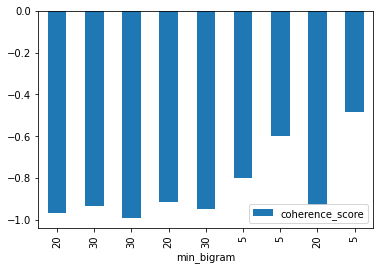

In [25]:
df_grams.sort_values('dist_to_ideal', ascending = False).plot(x='min_bigram',y='coherence_score', kind = 'bar')

Better both coherence and distance to ideal when we are less restrictive with bigrams and trigrams

#### Tuning no_below and no_above

In [7]:
# grid search
no_belows = [10,20,40]
no_aboves = [0.7]
min_bigrams = [20]
min_trigrams = [15]
ks = [10]
grid_extremes = [[b,a,k,bi,tri] for b in no_belows for a in no_aboves for k in ks for bi in min_bigrams for tri in min_trigrams]
len(grid_extremes)

3

In [10]:
df_extremes = lda_gs(grid_extremes,df)  

Processing for params no_below = 10, no_above = 0.7, k = 10, min_bigram = 20, min_trigram = 15 (1/3)...
Fitting...
Evaluating...
Calculating coherence...
...coherence score: -0.540549297086317 ; avg. distance to ideal: 0.4088763745561431
...estimated time till end: 1.6780441602071126 minutes ...
Processing for params no_below = 20, no_above = 0.7, k = 10, min_bigram = 20, min_trigram = 15 (2/3)...
Fitting...
Evaluating...
Calculating coherence...
...coherence score: -0.5923089049996124 ; avg. distance to ideal: 0.3950420837532934
...estimated time till end: 0.8174088517824809 minutes ...
Processing for params no_below = 40, no_above = 0.7, k = 10, min_bigram = 20, min_trigram = 15 (3/3)...
Fitting...
Evaluating...
Calculating coherence...
...coherence score: -0.6209863000497762 ; avg. distance to ideal: 0.43615355105367104
...estimated time till end: 0.0 minutes ...


In [11]:
df_extremes.to_csv('csv/df_extremes_below.csv')

### Tuninng number of topics

In [12]:
# grid search
no_belows = [20]
no_aboves = [0.7]
min_bigrams = [20]
min_trigrams = [10]
ks = [8,10,15]
grid_topics = [[b,a,k,bi,tri] for b in no_belows for a in no_aboves for k in ks for bi in min_bigrams for tri in min_trigrams]
len(grid_topics)

df_topics = lda_gs(grid_topics,df) 

Processing for params no_below = 20, no_above = 0.7, k = 8, min_bigram = 20, min_trigram = 10 (1/3)...
Fitting...
Evaluating...
Calculating coherence...
...coherence score: -0.9338019028649018 ; avg. distance to ideal: 0.4264185810975575
...estimated time till end: 1.5412134250005087 minutes ...
Processing for params no_below = 20, no_above = 0.7, k = 10, min_bigram = 20, min_trigram = 10 (2/3)...
Fitting...
Evaluating...
Calculating coherence...
...coherence score: -1.0313382541681873 ; avg. distance to ideal: 0.45986824499428114
...estimated time till end: 0.8661614934603373 minutes ...
Processing for params no_below = 20, no_above = 0.7, k = 15, min_bigram = 20, min_trigram = 10 (3/3)...
Fitting...
Evaluating...
Calculating coherence...
...coherence score: -1.1005325595987339 ; avg. distance to ideal: 0.4815155125113625
...estimated time till end: 0.0 minutes ...


In [13]:
df_topics.to_csv('csv/df_topics.csv')
df_topics

,K,no_below,no_above,min_bigram,min_trigram,coherence_score,dist_to_ideal
0,8,20,0.7,20,10,-0.933802,0.426419
1,10,20,0.7,20,10,-1.031338,0.459868
2,15,20,0.7,20,10,-1.100533,0.481516


# Fitting final LDA on corpus of encyclicals of all popes

In [38]:
# final model for all popes
model,corpus,dictionary = train_lda(df['enc_text_lem'],
              preprocess=False,
              render_html=True,
              save_model=True,
              return_corp_and_dict=True,
              model_name="ALL_POPES",
              kwargs_for_preprocess={    'cleanup' : True,
                                         'stopwords'  : True,
                                         'tokenize'  : True,
                                         'lemmatize'  : True,
                                         'add_stopwords'  : add_stopwords,
                                         'add_chars_to_clean'  : add_characters_to_clean,
                                    },
              kwargs_for_lda={  'k':8,
                                'passes':15
                             },
              add_kwargs={         'min_bigram' : 5,
                                   'min_trigram' : 3,
                                   'no_below' : 20,
                                   'no_above' : 0.7
                                }
             )

Saving model as model_ALL_POPES.gensim


c:\users\wmasl\appdata\local\programs\python\python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


## Evaluating result

In [16]:
dictionary = corpora.Dictionary.load('pickles/dictionary_ALL_POPES.gensim')
corpus = pickle.load(open('pickles/corpus_ALL_POPES', 'rb'))
lda = models.ldamodel.LdaModel.load('models/model_ALL_POPES.gensim')

In [19]:
compute_coherence_values(lda,corp=corpus)

Calculating coherence...


-0.528560939497797

In [22]:
_,dti = how_far_from_ideal(lda)
print(f'The distance to ideal is: {dti}')

The distance to ideal is: 0.38661726117421125


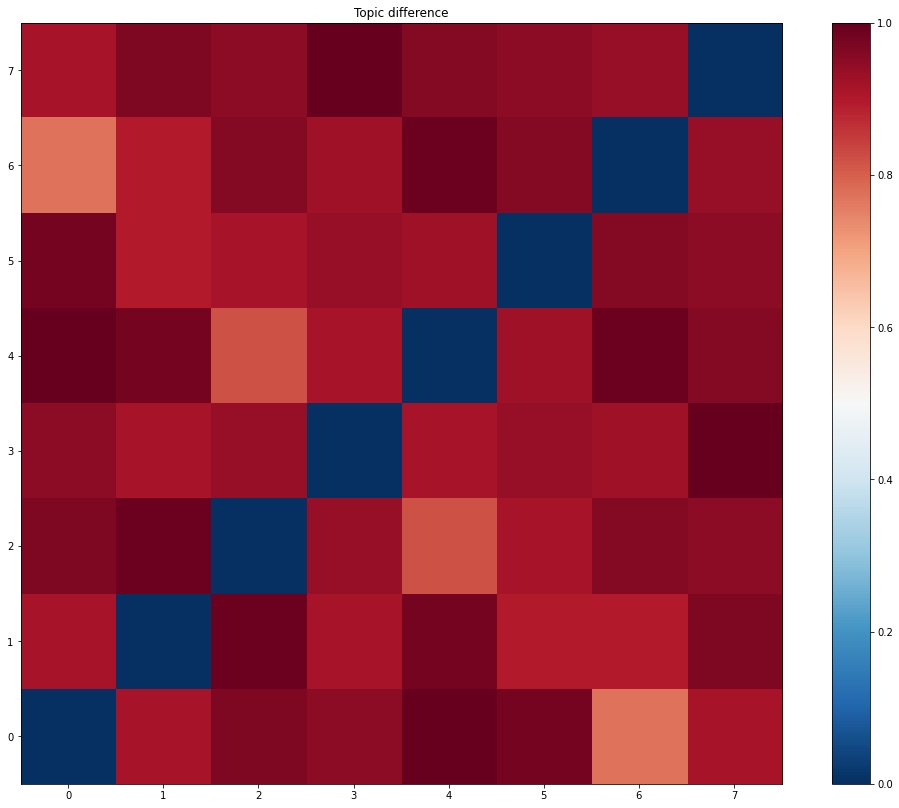

In [24]:
diff,ann = plot_difference(lda)

# Appendix
### Fitting LDA for each pope individually

We will also look at each pope separately and try model topics contained within encyclicals of each pope individually.

So for popes who wrote short encyclicals K should be roughly equal to the number of encyclicals, while for those who wrote long ones it can be more than that

* $N_{topics} \propto N_{encyclicals}$
* $N_{topics} \propto (avg.length_{encyclicals.of.pope} - avg.length_{all.encyclicals})^+$  
* $N_{topics} \geq  N_{encyclicals},$

where we denote $(x)^+ := \max(0,x) $ 

$$ N_{topics} = N_{encyclicals} + \frac{(avg.length_{encyclicals.of.pope} - avg.length_{all.encyclicals})^+}{\sigma_{all.encyclicals}}, $$ 
where $\sigma_{all.encyclicals}$ is the standard deviation of lengths of all encyclicals. In words, we set the number of topics to the number of encyclicals and we add "bonus" topics for every standard deviation above the average of all popes in sample.

While this formula seems appealing it unfortunately yielded very high number of topics for some of the popes. While a high number itself does not cause too much of a problem, it is troublesome for visualization and human inspection. Therefore I decided to cap the number of topics to 20, so the final formula is:
$$N_{topics.final} = \min(20,N_{topics})$$

We also set a little bit more restrictive constraints on the words to filter.

In [4]:
avg_len_all = np.median(df.enc_text.apply(lambda x: len(x)))
sd_len_all = np.std(df.enc_text.apply(lambda x: len(x)))
mult = 2
for pope in popes[6:]:
    df_pope = df[df['popes'] == pope].reset_index().copy()
    n_enc = len(df_pope)
    
    df_pope['len'] = df_pope.enc_text.apply(lambda x: len(x))
    avg_len_pope = np.mean(df_pope.len)
    k = n_enc + mult*np.floor(max(avg_len_pope-avg_len_all,0)/sd_len_all)
    k = min(20,k)
    _,__,___ = train_lda(df['enc_text_lem'],
              preprocess=False,
              render_html=True,
              save_model=True,
              return_corp_and_dict=True,
              model_name=pope,
              kwargs_for_preprocess={    'cleanup' : True,
                                         'stopwords'  : True,
                                         'tokenize'  : True,
                                         'lemmatize'  : True,
                                         'add_stopwords'  : add_stopwords,
                                         'add_chars_to_clean'  : add_characters_to_clean,
                                    },
              kwargs_for_lda={  'k':k,
                                'passes':15
                             },
              add_kwargs={         'min_bigram' : 20,
                                   'min_trigram' : 15,
                                   'no_below' : 10,
                                   'no_above' : 0.6
                                }
             )

Saving model as model_Pius XI.gensim


c:\users\wmasl\appdata\local\programs\python\python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


Saving model as model_Benedict XV.gensim


c:\users\wmasl\appdata\local\programs\python\python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


Saving model as model_Pius X.gensim


c:\users\wmasl\appdata\local\programs\python\python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


Saving model as model_Leo XIII.gensim


c:\users\wmasl\appdata\local\programs\python\python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
